Talk is to be timed for 22 minutes + 3 minutes for questions.

### Notes
1. Add image of a Treant.

In [12]:
# useful for when kernel dies
import datreant.core as dtr
import seaborn as sns
%matplotlib inline

In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'start_slideshow_at': 'selected',
              'width': 1024,
              'height': 768,
})

{'height': 768, 'start_slideshow_at': 'selected', 'width': 1024}

# datreant

### persistent, Pythonic trees for heterogeneous data

**David L. Dotson**, Sean L. Seyler, Max Linke,  
Richard Gowers, Oliver Beckstein

SciPy 2016, Austin

## the problem

Scientific research often proceeds organically.

[Need an image of a directory tree, perhaps randomly generated]

Though portions are planned, the process is largely messy; this is especially true for simulation work.

## possible solutions?

* relational databases?
* document databases?
* HDFS?

Rarely are these a good fit for the data one needs to store, including simulation parameters, system description, etc. Existing tools often require customary file formats.

## why not use the filesystem itself?

Cons:
* littered with irrelevant files
* hierarchical, but perhaps inconsistently strunctured

Pros:
* already stores anything we need (by definition)
* existing tools work with existing formats

**`datreant`** is an attempt to take advantage of the universality of the filesystem while minimizing its inconveniences

## Treants: discoverable directories with metadata

A ``Treant`` is a directory with a special **state file**:

In [2]:
import datreant.core as dtr

t = dtr.Treant('maple')
t.draw()

maple/
 +-- Treant.227a1d09-07fb-4421-8dc3-bd24a82b8ddf.json


The state file:
1. serves as a bookmark marking the directory as a ``Treant``.
2. stores metadata elements to distinguish the ``Treant``, such as *tags* and *categories*.

## introspecting and manipulating a Treant's tree

We can use a `Treant` to create directory structures:

In [3]:
t['a/place/for/data/'].makedirs()
t['a/place/for/text/'].makedirs()

t.draw()

maple/
 +-- Treant.227a1d09-07fb-4421-8dc3-bd24a82b8ddf.json
 +-- a/
     +-- place/
         +-- for/
             +-- data/
             +-- text/


And we can manipulate directories and files with `Tree` and `Leaf` objects, respectively.

For example, we could store a `pandas` DataFrame somewhere in the tree for reference later:

In [32]:
import pandas as pd
df = pd.DataFrame(pd.np.random.randn(3, 2),
                  columns=['A', 'B'])

In [46]:
data = t['a/place/for/data/']
data

<Tree: 'maple/a/place/for/data/'>

In [6]:
df.to_csv(data['random_dataframe.csv'].abspath)
data.draw()

data/
 +-- random_dataframe.csv


And we can introspect the file directly:

In [7]:
csv = data['random_dataframe.csv']
csv

<Leaf: 'maple/a/place/for/data/random_dataframe.csv'>

In [8]:
print(csv.read())

,A,B
0,0.0712579660664,0.154766035862
1,-0.224534062781,-0.0243116668594
2,0.289714381758,-0.430677153306



Using ``Treant``, ``Tree``, and ``Leaf`` objects, we can work with the filesystem Pythonically without giving much attention to *where* these objects live within that filesystem.

This becomes especially powerful when we have many directories/files we want to work with, possibly in many different places.

## Aggregating and splitting on Treant metadata

What makes a `Treant` distinct from a `Tree` is its **state file**. This file stores metadata that can be used to filter and split `Treant` objects when treated in aggregate.

If we have many more Treants, perhaps scattered about the filesystem:

In [9]:
for path in ('an/elm/', 'the/oldest/oak', 
             'the/oldest/tallest/sequoia'):
    dtr.Treant(path)

We can gather them up with ``datreant.core.discover``:

In [10]:
b = dtr.discover('.')
b

<Bundle([<Treant: 'oak'>, <Treant: 'sequoia'>, <Treant: 'maple'>, <Treant: 'elm'>])>

A `Bundle` is an ordered set of ``Treant`` objects. It gives convenient mechanisms for working with Treants as a single logical unit.

In [11]:
b.relpaths

['the/oldest/oak/', 'the/oldest/tallest/sequoia/', 'maple/', 'an/elm/']

In [12]:
b.names

['oak', 'sequoia', 'maple', 'elm']

A ``Bundle`` can subselect Treants in typical ways:

In [13]:
# integer indexing
b[1]

<Treant: 'sequoia'>

In [14]:
# slicing
b[1::2]

<Bundle([<Treant: 'sequoia'>, <Treant: 'elm'>])>

In [15]:
# fancy indexing
b[[3, 0, 1]]

<Bundle([<Treant: 'elm'>, <Treant: 'oak'>, <Treant: 'sequoia'>])>

In [16]:
# boolean indexing
b[[True, False, False, True]]

<Bundle([<Treant: 'oak'>, <Treant: 'elm'>])>

In [17]:
# indexing by name
b['oak']

<Bundle([<Treant: 'oak'>])>

### Treants can be filtered on their tags

Tags are individual strings that describe a `Treant`. Setting some tags for each of our Treants:

In [18]:
b['maple'].tags = ['syrup', 'furniture', 'plant']
b['sequoia'].tags = ['huge', 'plant']
b['oak'].tags = ['for building', 'plant', 'building']
b['elm'].tags = ['firewood', 'shady', 'paper', 'plant', 'building']

We can work with these tags in aggregate:

In [19]:
# will only show tags present in *all* members
b.tags

<AggTags([u'plant'])>

In [20]:
# will show tags present among *any* member
b.tags.any

{u'building',
 u'firewood',
 u'for building',
 u'furniture',
 u'huge',
 u'paper',
 u'plant',
 u'shady',
 u'syrup'}

And we can filter on them. For example, getting all Treants that are good for construction work:

In [21]:
# gives a boolean index for members with this tag
b.tags['building']

[True, False, False, True]

In [22]:
# we can use this to index the Bundle itself
b[b.tags['building']]

<Bundle([<Treant: 'oak'>, <Treant: 'elm'>])>

or getting back Treants that are both good for construction *and* used for making furniture by giving tags as a list:

In [23]:
# a list of tags serves as an *intersection* query
b[b.tags[['building', 'furniture']]]

<Bundle([])>

which in this case none of them are.

Other tag expressions can be constructed using tuples (for *union* operations) and sets (for *negated intersections*), and nesting of any of these works as expected:

In [24]:
# we can get a *union* by using a tuple instead of a list
b[b.tags['building', 'furniture']]

<Bundle([<Treant: 'oak'>, <Treant: 'maple'>, <Treant: 'elm'>])>

In [25]:
# and we can get a *negated intersection* by using a set
b[b.tags[{'building', 'furniture'}]]

<Bundle([<Treant: 'oak'>, <Treant: 'sequoia'>, <Treant: 'maple'>, <Treant: 'elm'>])>

Using tag expressions, we can filter to Treants of interest from a ``Bundle`` counting many, perhaps hundreds, of Treants as members.

### Splitting Treants on categories

Categories are key-value pairs that provide another mechanism for distinguishing Treants. We can add categories to each Treant:

In [26]:
# add categories to individual members
b['oak'].categories = {'age': 'adult',
                       'type': 'deciduous',
                       'bark': 'mossy'}
b['elm'].categories = {'age': 'young',
                       'type': 'deciduous',
                       'bark': 'smooth'}
b['maple'].categories = {'age': 'young',
                         'type': 'deciduous',
                         'bark': 'mossy'}
b['sequoia'].categories = {'age': 'old',
                           'type': 'evergreen',
                           'bark': 'fibrous',
                           'home': 'california'}

# add value 'tree' to category 'plant' for all members
b.categories.add({'plant': 'tree'})

And we can access categories for individual Treants:

In [27]:
seq = b['sequoia'][0]
seq.categories

<Categories({u'home': u'california', u'plant': u'tree', u'type': u'evergreen', u'age': u'old', u'bark': u'fibrous'})>

or the aggregated categories for all members in the `Bundle`:

In [28]:
b.categories

<AggCategories({u'plant': [u'tree', u'tree', u'tree', u'tree'], u'type': [u'deciduous', u'evergreen', u'deciduous', u'deciduous'], u'age': [u'adult', u'old', u'young', u'young'], u'bark': [u'mossy', u'fibrous', u'mossy', u'smooth']})>

Categories are useful for making decisions on how to treat different Treants. When many Treants possess the same category keys, we can take a "split-apply-combine" approach to working with them using `groupby`:

In [29]:
b.categories.groupby('bark')

{u'fibrous': <Bundle([<Treant: 'sequoia'>])>,
 u'mossy': <Bundle([<Treant: 'oak'>, <Treant: 'maple'>])>,
 u'smooth': <Bundle([<Treant: 'elm'>])>}

And we could group on more than one key:

In [30]:
b.categories.groupby(['bark', 'home'])

{(u'fibrous', u'california'): <Bundle([<Treant: 'sequoia'>])>}

Since only one `Treant` in this `Bundle` has the `"home"` category, we only get the one group with a single `Treant` included. By leveraging the `groupby` method, we can then extract the Treants by selected categories without having to explicitly access each member.

## Attachable Limbs make for modular Treants

`Tags` and `Categories` are examples of ``Limb`` objects.
Custom ``Limb`` subclasses can be attached to Treants for additional functionality.

``datreant`` is a namespace package; the core components are included in the dependency-light ``datreant.core`` module.

The package ``datreant.data`` implements a convenience interface for storing, retrieving, and aggregating `pandas` objects and `numpy` arrays using HDF5 (with PyTables and `h5py`, respectively).

In [3]:
import datreant.data
t = dtr.Treant('maple')

# attach the `data` limb, available on import of `datreant.data`
t.attach('data')
t.data

<Data([])>

We can immediately start using it to store e.g. a Pandas ``Series``:

In [5]:
import numpy as np
import pandas as pd
sn = pd.Series(np.sin(np.linspace(0, 8*np.pi, num=200)))
t.data['sinusoid'] = sn

and we can get it back just as easily:

In [6]:
t.data['sinusoid'].head()

0    0.000000
1    0.125960
2    0.249913
3    0.369885
4    0.483966
dtype: float64

The `data` interface stores the `Series` in an HDF5 file, with the name of the dataset corresponding to its path in the tree:

In [10]:
t.draw()

maple/
 +-- sinusoid/
 |   +-- pdData.h5
 +-- a/
 |   +-- place/
 |       +-- for/
 |           +-- text/
 |           +-- data/
 |               +-- random_dataframe.csv
 +-- Treant.227a1d09-07fb-4421-8dc3-bd24a82b8ddf.json


``datreant.data`` also includes a corresponding ``AggLimb`` for ``Bundle`` objects, which can do automatic aggregation of datasets by name across all member ``Treant`` objects.

If we collect and store similar datasets for each member in our ``Bundle``:

In [18]:
b = dtr.discover('.')

# attaches the `data` limb to everything
import datreant.data.attach

# we want to make each dataset a bit different
b.categories['frequency'] = [1, 2, 3, 4]
x = np.linspace(0, 8*np.pi, num=200)
for mem in b:
    freq = mem.categories['frequency']
    mem.data['sinusoid'] = pd.Series(np.sin(freq * x),
                                     index=pd.Float64Index(x))

we can then retrieve them all into a single, multi-index Pandas `Series`:

In [19]:
sines = b.data.retrieve('sinusoid', by='name')
sines.groupby(level=0).head()

elm      0.000000    0.000000
         0.126295    0.483966
         0.252590    0.847024
         0.378886    0.998474
         0.505181    0.900479
maple    0.000000    0.000000
         0.126295    0.369885
         0.252590    0.687304
         0.378886    0.907232
         0.505181    0.998474
oak      0.000000    0.000000
         0.126295    0.125960
         0.252590    0.249913
         0.378886    0.369885
         0.505181    0.483966
sequoia  0.000000    0.000000
         0.126295    0.249913
         0.252590    0.483966
         0.378886    0.687304
         0.505181    0.847024
dtype: float64

We can use this directly for aggregated analysis, or just pretty plots:

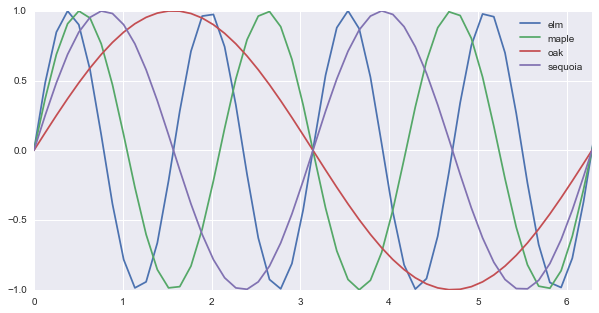

In [33]:
for name in sines.index.levels[0]:
    sines.loc[name].plot(legend=True, label=name, xlim=(0, 2*np.pi), figsize=(10,5))

The ``Data`` Limb makes data storage and retrieval convenient.

However, It mainly serves as an example for how ``Treant`` and ``Bundle`` objects can be extended to do complex but convenient things.

## Treants + the PyData stack

It's not necessary to build specialized Limbs to make use of the PyData stack. 

``datreant`` fundamentally serves as a Pythonic interface to the filesystem, bringing value to datasets and analysis results by making them easily accessible now and later.

As data structures and file formats change, ``datreant`` objects can always be used in the same way to supplement the way these tools are used.

[subslide on using distributed, with a toy example]

[subslide on using a workflow automation system like Fireworks,
showing how `datreant` makes this easier]

## Building domain-specific applications on datreant

[summary detail, probably a diagram, showing how Treants and Bundles
are able to work just fine with `Treant` subclasses]

## Leveraging molecular dynamics data with MDSynthesis

[steal example from paper, or perhaps make a simpler one? existing example isn't fast enough to do live (if that's desired)]

## A growing development community

## Final thoughts

## Acknowledgments